# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import scipy

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Read data

In [4]:
uns = pd.read_csv('uns_df.csv', index_col=0)
isri = pd.read_csv('isri_df.csv', index_col=0)
process = pd.read_csv('process_df.csv', index_col=0)
anamet = pd.read_csv('anamet_df.csv', index_col=0)
materials = pd.read_csv('materials_df.csv', index_col=0)

# Read updated *Nikos* data

In [5]:
xls = pd.ExcelFile('data/edited_nikos_data.xlsx')
xls.sheet_names

['ANAMET',
 'Anamet data',
 'ISRI',
 'Isri data',
 'UNS data',
 'Elements data',
 'Material data',
 'Process']

In [6]:
uns_data = pd.read_excel(xls, 'UNS data')

uns_data.rename(columns = {'sc:isComposedOf':'elements id'}, inplace = True)

elements_data = pd.read_excel(xls, 'Elements data')

uns_data = pd.merge(uns_data, elements_data, how='inner', on = 'elements id')
isri_data = pd.read_excel(xls, 'Isri data')
anamet_data = pd.read_excel(xls, 'Anamet data')
material_data = pd.read_excel(xls, 'Material data')
elements_data = pd.read_excel(xls, 'Elements data')

# Raw data preprocessing

In [7]:
isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasISRICode,sc:hasSpecification,pc:hasName,sc:isComposedOf,sc:isProcessedBy
0,sc:ISRI_0,Nonferrous Scrap - Red Metals,Wire,NaN,Copper,Berry,"Bare, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257
1,sc:ISRI_1,Nonferrous Scrap - Red Metals,Wire and Cable,"Brittle Burnt Wire, Copper Tubing",Copper,Barley,"Clean, Untinned, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257


In [8]:
isri_data.shape

(244, 10)

In [9]:
isri_data.isna().sum()

isri id                  0
sc:hasCategory           0
sc:hasForm              43
sc:isFreeFrom           87
sc:contains             68
sc:hasISRICode           0
sc:hasSpecification     12
pc:hasName               7
sc:isComposedOf        109
sc:isProcessedBy       194
dtype: int64

#### Drop unusefull columns

In [10]:
df = isri_data.copy()
df.drop(columns=['isri id', 'sc:hasISRICode', 'sc:isProcessedBy'], inplace=True)
df.shape

(244, 7)

In [11]:
import texthero as hero
from texthero import preprocessing

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords]

for col in df.drop('sc:isComposedOf',axis=1).columns:
    df[col] = hero.clean(df[col])

df.head()


,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasSpecification,pc:hasName,sc:isComposedOf
0,nonferrous scrap red metals,wire,,copper,bare uncoated unalloyed,copper wire,sc:Material_249
1,nonferrous scrap red metals,wire cable,brittle burnt wire copper tubing,copper,clean untinned uncoated unalloyed,copper wire,sc:Material_249
2,nonferrous scrap red metals,miscellaneous wire,excessively leaded tinned soldered copper wire...,copper,unalloyed,copper wire,sc:Material_249
3,nonferrous scrap red metals,clippings punchings bus bars commutator segmen...,,copper,clean unalloyed uncoated,heavy copper solids tubing,sc:Material_249
4,nonferrous scrap red metals,miscellaneous scrap,excessively leaded tinned soldered copper scra...,copper,unalloyed,copper solids tubing,sc:Material_249


In [12]:
df.isna().sum()

sc:hasCategory           0
sc:hasForm               0
sc:isFreeFrom            0
sc:contains              0
sc:hasSpecification      0
pc:hasName               0
sc:isComposedOf        109
dtype: int64

## Predict `sc:isComposedOf`

#### TfIdfVectorizer

In [13]:
df = df[df['sc:isComposedOf'].notna()]
df.shape

(135, 7)

In [14]:
df['corpus'] = df['sc:hasCategory']
df['corpus'] = df['sc:hasCategory'] + ' ' + df['sc:hasSpecification'] + ' ' + df['sc:hasForm'] + df['sc:contains']

# for col in df.drop(['sc:hasCategory', 'sc:isComposedOf'], axis=1):
#     df['corpus'] = df['corpus'] + ' ' + df[col]

# df.shape

In [15]:
df.head(2)

,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasSpecification,pc:hasName,sc:isComposedOf,corpus
0,nonferrous scrap red metals,wire,,copper,bare uncoated unalloyed,copper wire,sc:Material_249,nonferrous scrap red metals bare uncoated unal...
1,nonferrous scrap red metals,wire cable,brittle burnt wire copper tubing,copper,clean untinned uncoated unalloyed,copper wire,sc:Material_249,nonferrous scrap red metals clean untinned unc...


In [16]:
from sklearn.model_selection import train_test_split

# X = df.drop('sc:isComposedOf', axis=1)
X = df['corpus']
y = df['sc:isComposedOf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# X_train = X_train['sc:hasCategory'].values
# X_test = X_test['sc:hasCategory'].values

y_train = y_train.values
y_test = y_test.values

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

print(train_vectors.shape, test_vectors.shape)

(108, 489) (27, 489)


In [17]:
X

0      nonferrous scrap red metals bare uncoated unal...
1      nonferrous scrap red metals clean untinned unc...
2      nonferrous scrap red metals unalloyed miscella...
3      nonferrous scrap red metals clean unalloyed un...
4      nonferrous scrap red metals unalloyed miscella...
                             ...                        
228    ferrous scrap specially processed grades meet ...
229    ferrous scrap specially processed grades meet ...
230    ferrous scrap specially processed grades meet ...
231    ferrous scrap specially processed grades meet ...
232    ferrous scrap specially processed grades meet ...
Name: corpus, Length: 135, dtype: object

In [15]:
model = LogisticRegression()

model.fit(train_vectors, y_train)
predicted = model.predict(test_vectors)
print(accuracy_score(y_test,predicted))

results = pd.DataFrame(columns=['true', 'pred'])
results['true'] = y_test
results['pred'] = predicted

0.4444444444444444


In [16]:
from sklearn.svm import SVC

model = SVC(C=100, gamma=.1)

model.fit(train_vectors, y_train)
predicted = model.predict(test_vectors)
print(accuracy_score(y_test,predicted))

results = pd.DataFrame(columns=['true', 'pred'])
results['true'] = y_test
results['pred'] = predicted

0.7777777777777778


In [17]:
results

,true,pred
0,sc:Material_254,sc:Material_254
1,sc:Material_706,sc:Material_707
2,sc:Material_255,sc:Material_244
3,sc:Material_249,sc:Material_249
4,sc:Material_254,sc:Material_254
5,sc:Material_249,sc:Material_249
6,sc:Material_707,sc:Material_707
7,sc:Material_703,sc:Material_703
8,sc:Material_701,sc:Material_701
9,sc:Material_696,sc:Material_696


# Study `UNS`

In [45]:
uns_data

,uns id,sc:hasName,elements id,ar,atomicNumber,density,meltingPoint,hasName,symbol
0,sc:UNS_712,C83300,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
1,sc:UNS_733,C84500,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
2,sc:UNS_738,C85310,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
3,sc:UNS_752,C85710,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
4,sc:UNS_837,C91500,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
...,...,...,...,...,...,...,...,...,...
907,sc:UNS_1657,C50200,sc:Elements_943,32.605,16,2.07,112.8,SULFUR,S
908,sc:UNS_1305,NaN,sc:Elements_943,32.605,16,2.07,112.8,SULFUR,S
909,sc:UNS_1654,NaN,sc:Elements_943,32.605,16,2.07,112.8,SULFUR,S
910,sc:UNS_1767,C70280,sc:Elements_946,10.811,5,2.34,2076.0,BORON,B


In [46]:
uns_data.drop('sc:hasName', axis=1, inplace=True)

In [47]:
uns_data.isna().sum()

uns id          0
elements id     0
ar              0
atomicNumber    0
density         0
meltingPoint    0
hasName         0
symbol          0
dtype: int64

In [48]:
print(uns_data['uns id'].nunique(), "unique UNS-type scraps.")

912 unique UNS-type scraps.


In [51]:
print(uns_data['hasName'].nunique())
print(uns_data['hasName'].unique())

25
['LEAD' 'COPPER' 'TIN' 'NICKEL' 'ZINC' 'MANGANESE' 'IRON' 'BISMUTH'
 'ALUMINUM' 'ANTIMONY' 'SILICON' 'MAGNESIUM' 'SILVER' 'CHROMIUM'
 'BERYLLIUM' 'PHOSPHORUS' 'ARSENIC' 'COBALT' 'ZIRCONIUM' 'CARBON'
 'TITANIUM' 'OXYGEN' 'CADMIUM' 'SULFUR' 'BORON']


In [57]:
elements_data

,elements id,ar,atomicNumber,density,meltingPoint,hasName,symbol
0,sc:Elements_319,63.546000,29,8.960,1085.00,COPPER,Cu
1,sc:Elements_320,47.867000,22,4.500,1668.00,TITANIUM,Ti
2,sc:Elements_321,55.845000,26,7.874,1538.00,IRON,Fe
3,sc:Elements_322,26.981539,13,2.700,660.30,ALUMINUM,Al
4,sc:Elements_323,24.305000,12,1.738,650.00,MAGNESIUM,Mg
5,sc:Elements_324,6.941000,3,534.000,180.50,LITHIUM,Li
6,sc:Elements_325,186.207000,75,21.020,3185.00,RHENIUM,Re
7,sc:Elements_326,118.710000,50,5.750,231.90,TIN,Sn
8,sc:Elements_327,58.693400,28,8.902,1455.00,NICKEL,Ni
9,sc:Elements_328,65.380000,30,7.130,419.50,ZINC,Zn


### Clustering on `UNS` types

In [26]:
uns_data.drop(columns=['elements id', 'hasName', 'symbol'], inplace=True)

In [29]:
uns_data.head(2)

,uns id,ar,atomicNumber,density,meltingPoint
0,sc:UNS_712,207.2,82,11.29,327.5
1,sc:UNS_733,207.2,82,11.29,327.5


In [30]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()

uns_data['uns id'] = label_enc.fit_transform(uns_data['uns id'])
uns_data.head(2)

,uns id,ar,atomicNumber,density,meltingPoint
0,679,207.2,82,11.29,327.5
1,700,207.2,82,11.29,327.5


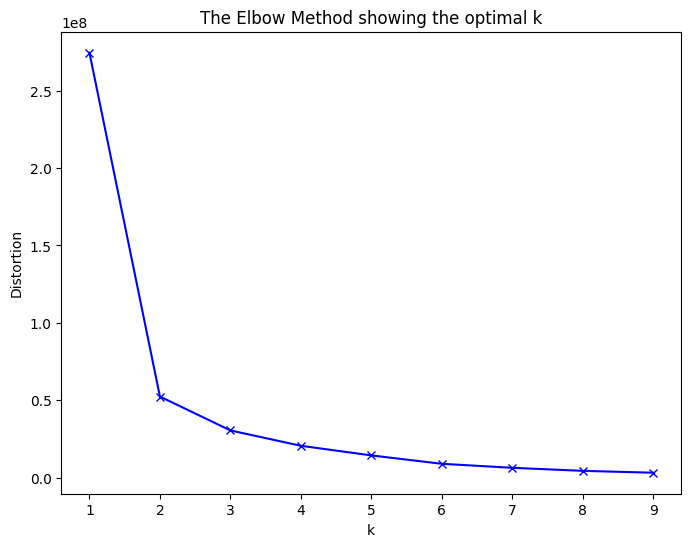

In [34]:
from sklearn.cluster import KMeans

df = uns_data.drop('uns id', axis=1).copy()

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [35]:
opt_k = 3
kmeans = KMeans(n_clusters=opt_k)
kmeans.fit(df)

KMeans(n_clusters=3)

In [39]:
uns_data['cluster'] = kmeans.labels_

In [40]:
uns_data

,uns id,ar,atomicNumber,density,meltingPoint,cluster
0,679,207.200,82,11.29,327.5,1
1,700,207.200,82,11.29,327.5,1
2,705,207.200,82,11.29,327.5,1
3,719,207.200,82,11.29,327.5,1
4,804,207.200,82,11.29,327.5,1
...,...,...,...,...,...,...
907,372,32.605,16,2.07,112.8,1
908,29,32.605,16,2.07,112.8,1
909,369,32.605,16,2.07,112.8,1
910,481,10.811,5,2.34,2076.0,2


# Study `ANAMET`

In [96]:
anamet_data

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
0,sc:ANAMET_437,ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ),Ferrous,40000,sc:Process_690
1,sc:ANAMET_438,άγνωστο,Ferrous,9000,NaN
2,sc:ANAMET_439,κουτάκι,Ferrous,9101,NaN
3,sc:ANAMET_440,λαμαρίνες,Ferrous,9102,NaN
4,sc:ANAMET_441,ζάντες + βαρύ προς shredder κλπ από ΟΤΚΖ,Ferrous,9103,NaN
...,...,...,...,...,...
317,sc:ANAMET_684,LEAD SCRAP (E),Non-Ferrous,50185,NaN
318,sc:ANAMET_685,ELECTRIC MOTORS SHREDDED (WEEE),Non-Ferrous,50259,NaN
319,sc:ANAMET_686,BLACK PLASTIC SCRAP (WEEE) ( E ),Non-Ferrous,50117,NaN
320,sc:ANAMET_687,SCRAP PLEXIGLASS ( E ),Non-Ferrous,50118,NaN


# Unified dataset

In [97]:
uns_data = pd.read_excel(xls, 'UNS data')

uns_data.rename(columns = {'sc:isComposedOf':'elements id'}, inplace = True)

elements_data = pd.read_excel(xls, 'Elements data')

uns_data = pd.merge(uns_data, elements_data, how='inner', on = 'elements id')
isri_data = pd.read_excel(xls, 'Isri data')
anamet_data = pd.read_excel(xls, 'Anamet data')
material_data = pd.read_excel(xls, 'Material data')
elements_data = pd.read_excel(xls, 'Elements data')

How many __unique__ ISRI?

In [ ]:
isri_data['isri id'].nunique()

In [ ]:
# check nans
isri_data.isna().sum()

Όσα `ISRI` έχουν available `process`, ανήκουν στο ίδιο. Επομένως, δεν έχει νοήμα η προσπάθεια πρόβλεψης του process κάποιου scrap.

In [ ]:
print(isri_data['sc:isProcessedBy'].unique())

# drop process from ISRI
isri_data.drop('sc:isProcessedBy', axis=1, inplace=True)

In [ ]:
isri_data['sc:hasCategory'].value_counts()

In [ ]:
isri_data.head(2)

#### Check for NaNs and fill them with empty string

In [ ]:
isri_data.isna().sum()

In [ ]:
# isri_data.fillna('', inplace=True)

In [ ]:
# Probably just a 'code name'. We will drop it
isri_data.drop('sc:hasISRICode', axis=1, inplace=True)

In [ ]:
isri_data.head(2)

# TDS: How to vectorize text in DF for NLP

In [ ]:
import texthero as hero
from texthero import preprocessing

In [ ]:
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords]

df = isri_data.copy()

In [ ]:
df.head()

In [ ]:
reviews = df['sc:hasCategory'].str.cat(sep=' ')

In [ ]:
le = LabelEncoder()

df['sc:isComposedOf'] = le.fit_transform(df['sc:isComposedOf'])
df.head(2)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('sc:isComposedOf', axis=1)
y = df['sc:isComposedOf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = X_train['sc:hasCategory'].values
X_test = X_test['sc:hasCategory'].values

y_train = y_train.values
y_test = y_test.values

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

print(train_vectors.shape, test_vectors.shape)

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

In [ ]:
pd.DataFrame(train_vectors.todense())

In [ ]:
train_vectors.todense()

In [ ]:
for col in X_train.columns:
    vectorizer = TfidfVectorizer()
    train_vectors = vectorizer.fit_tr
    print(col)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

X = df['sc:hasCategory']

cvec = CountVectorizer().fit(X)
X = cvec.transform(X)
df_train = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())
df_train

In [ ]:
for col in df.drop('sc:isComposedOf', axis=1).columns:
    df[col] = hero.clean(df[col])
    df[col] = df[col].pipe(hero.clean, custom_pipeline)

df.head()


In [ ]:
for col in df.drop('sc:isComposedOf', axis=1).columns:
    df[col] = hero.tfidf(df[col])

df.head()

In [ ]:
print(df.isna().sum())

df.fillna('', inplace=True)

In [ ]:
pred_isComposedOf_df = df[df['sc:isComposedOf'] != '']
pred_isComposedOf_df.shape


In [ ]:
le = LabelEncoder()

pred_isComposedOf_df['sc:isComposedOf'] = le.fit_transform(pred_isComposedOf_df['sc:isComposedOf'])
pred_isComposedOf_df.head(2)

In [ ]:
from sklearn.model_selection import train_test_split

X = pred_isComposedOf_df.drop('sc:isComposedOf', axis=1)
y = pred_isComposedOf_df['sc:isComposedOf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression())

model.fit(X_train['sc:hasCategory'], y_train)
y_hat = model.predict(X_test)

results = pd.DataFrame()

results['true'] = y_test
results['pred'] = y_hat

accuracy_score(y_test, y_hat)

In [ ]:
pred_isComposedOf_df = isri_data[isri_data['sc:isComposedOf'] != '']
pred_isComposedOf_df.drop(columns=['isri id', 'sc:isFreeFrom'], inplace=True)
pred_isComposedOf_df.head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# columns = ['sc:hasCategory', 'pc:hasName']
columns = pred_isComposedOf_df.columns

for col_name in columns:
    
    if col_name == 'sc:isComposedOf': continue
    else:
            
        text = isri_data[col_name]

        df = pd.DataFrame()
        df['corpus'] = text
        df['cleaned'] = df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

        pred_isComposedOf_df[col_name] = df['cleaned']

        del df

In [ ]:
pred_isComposedOf_df

In [ ]:
def cluster_text(text, true_k):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(text)

    return X

   #  Sum_of_squared_distances = []
   #  K = range(2,10)
   #  for k in K:
   #     km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   #     km = km.fit(X)
   #     Sum_of_squared_distances.append(km.inertia_)
   #  plt.plot(K, Sum_of_squared_distances, 'bx-')
   #  plt.xlabel('k')
   #  plt.ylabel('Sum_of_squared_distances')
   #  plt.title('Elbow Method For Optimal k')
   #  plt.show()

   # #  true_k = 6
   #  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
   #  model.fit(X)

   #  labels=model.labels_
   #  clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
   #  #print(clusters.sort_values(by=['cluster']))
       
   #  return clusters

In [ ]:
X = cluster_text(pred_isComposedOf_df['sc:hasCategory'], 6)
X.shape

In [ ]:
for mat in pred_isComposedOf_df['sc:isComposedOf'].value_counts().tail(15).index.values:

    pred_isComposedOf_df = pred_isComposedOf_df[pred_isComposedOf_df['sc:isComposedOf'] != mat]

In [ ]:
from sklearn.model_selection import train_test_split

X = pred_isComposedOf_df.drop('sc:isComposedOf', axis=1)
y = pred_isComposedOf_df['sc:isComposedOf']

X = cluster_text(X['sc:hasCategory'], 6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression())

model.fit(X_train, y_train)
y_hat = model.predict(X_test)

results = pd.DataFrame()

results['true'] = y_test
results['pred'] = y_hat

accuracy_score(y_test, y_hat)

In [ ]:
isri_data['cluster_category'] = cluster_text(isri_data['sc:hasCategory'], 6)['cluster']
isri_data.head(2)

In [ ]:
isri_data['cluster_hasName'] = cluster_text(isri_data['pc:hasName'], 5)['cluster']
isri_data.head(2)

In [ ]:
 isri_data[isri_data['cluster_hasName'] == 1]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

df = pred_isComposedOf_df.copy()
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['sc:isComposedOf'])
Y = multilabel_binarizer.transform(df['sc:isComposedOf'])

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df['sc:hasCategory'])

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)


In [ ]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, Y, 
                    test_size=0.2, random_state=2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("Accuracy: {}".format(accuracy_score(y_pred, y_test_tfidf)))
    print("---")    

nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()
mn = MultinomialNB()

for classifier in [nb_clf, sgd, lr, mn]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)

Keep only `anamets` with english description

In [ ]:
# Keep only anamets with english sc:descritpion
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

e_description_index = []
for row in range(len(anamet_data)):
    if only_roman_chars(str(anamet_data['sc:description'].iloc[row])):
        e_description_index.append(row)
        
anamet_data = anamet_data.iloc[e_description_index]

In [ ]:
uns_data.head(2)

In [ ]:
isri_data.head(2)

In [ ]:
anamet_data.head(2)

In [ ]:
print(uns_data.isna().sum(), '\n')
print(isri_data.isna().sum(), '\n')
print(anamet_data.isna().sum(), '\n')

In [ ]:
anamet_data['sc:hasCategory'].value_counts()

In [ ]:
isri_data

In [ ]:
isri_data['sc:isProcessedBy'].value_counts()

In [ ]:
isri_for_ml = isri_data.drop(columns=['isri id', 'pc:hasName', 'sc:isProcessedBy'])

# NLP

Keep only `anamets` with english description

## ANAMET `anamet_data`

In [ ]:
# Keep only anamets with english sc:descritpion
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

e_description_index = []
for row in range(len(anamet_data)):
    if only_roman_chars(str(anamet_data['sc:description'].iloc[row])):
        e_description_index.append(row)
        
anamet_data = anamet_data.iloc[e_description_index]
anamet_data

Preprocess text data using `gensim.utils.simple_preprocess()`

In [ ]:
anamet_data['sc:description'] = anamet_data['sc:description'].apply(simple_preprocess)
anamet_data.head(2)

Delete word `scrap` and `for` from description

In [ ]:
# Delete word scrap
for i in range(len(anamet_data)):
    if 'scrap' in anamet_data['sc:description'].iloc[i]:
        anamet_data['sc:description'].iloc[i].remove('scrap')
    if 'for' in anamet_data['sc:description'].iloc[i]:
        anamet_data['sc:description'].iloc[i].remove('for')

In [ ]:
anamet_data.head(2)

## UNS `uns_data`

In [ ]:
uns_data['hasName'] = uns_data['hasName'].apply(simple_preprocess)
uns_data.head(2)

Θέλουμε να συσχετίσουμε τα `anamet` με τα `uns`. Οι μόνες πληροφορίες που έχουμε (features) είναι το `sc:description` και `hasName`. Θα εφαρμόσουμε NLP και ειδικότερα Word2Vec για ομοιότητες μεταξύ των texts.

In [ ]:
print(anamet_data['anamet entity'].nunique(), "unique anamet ids")
print(uns_data['uns id'].nunique(), "unique uns ids")

## ISRI `isri_data`

In [ ]:
isri_data.head(2)

In [ ]:
isri_data.drop(columns=['sc:isComposedOf', 'sc:isProcessedBy'], inplace=True)

In [ ]:
isri_data.isna().sum()


In [ ]:
isri_data.fillna('nan', inplace=True)
isri_data.isna().sum()

In [ ]:
isri_data['sc:hasCategory'] = isri_data['sc:hasCategory'].apply(simple_preprocess)
isri_data['sc:hasForm'] = isri_data['sc:hasForm'].apply(simple_preprocess)
isri_data['sc:isFreeFrom'] = isri_data['sc:isFreeFrom'].apply(simple_preprocess)
isri_data['sc:contains'] = isri_data['sc:contains'].apply(simple_preprocess)
isri_data['sc:hasISRICode'] = isri_data['sc:hasISRICode'].astype(str).apply(simple_preprocess)
isri_data['sc:hasSpecification'] = isri_data['sc:hasSpecification'].apply(simple_preprocess)
isri_data['pc:hasName'] = isri_data['pc:hasName'].apply(simple_preprocess)

In [ ]:
isri_data.head(3)

Delete word `scrap` and `for` from description

In [ ]:
# Delete word scrap
for i in range(len(isri_data)):
    if 'scrap' in isri_data['sc:hasCategory'].iloc[i]:
        
        isri_data['sc:hasCategory'].iloc[i].remove('scrap')

### Try Word2Vec stuff

In [ ]:
import gensim
import gensim.downloader

# for model_name in list(gensim.downloader.info()['models'].keys()):
    # print(model_name)
    
model_pretrained = gensim.downloader.load('glove-twitter-25')
print(model_pretrained)

In [ ]:
# NLP preprocess
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

description = anamet_data['sc:description']
description

model_anamet = Word2Vec(min_count=1, 
                 vector_size=25, 
                 workers=4, 
                 window=2, 
                 sg=1)

model_anamet.build_vocab(description)
model_anamet.train(description, total_examples=model_anamet.corpus_count,
           epochs=500)
print(model_anamet)

#### Test example

In [ ]:
test_anamet = anamet_data.iloc[120]
print(test_anamet)
print('\n')
print(test_anamet['sc:description'])

In [ ]:
uns_data

In [ ]:
for row in range(len(uns_data)):
    w1 = uns_data['hasName'].iloc[row][0]
    w2 = 'copper'
    try:
        sim = model_anamet.wv.similarity(w1, w2)
    except KeyError:
        sim = model_pretrained.similarity(w1, w2)
    if sim >= .7: print(w1, w2, sim, uns_data['uns id'].iloc[row])

In [ ]:
model_anamet.wv.similarity('tin', test_anamet['sc:description'][0])

In [ ]:
model_pretrained.similarity('tin', test_anamet['sc:description'][0])

In [ ]:
anamet_data['sc:description']

In [ ]:
for row in range(200, 250):
    w1 = uns_data['hasName'].iloc[row][0]
    
    for j in range(3):
        try:
            w2 = anamet_data['sc:description'].iloc[j]
            print(w1, w2[0], model.similarity(w1, w2[0]))
        except KeyError:
            continue

# Clustering elements_data

In [ ]:
from gensim.utils import simple_preprocess

elements_data_df = elements_data[['ar', 'atomicNumber', 'density', 'meltingPoint', 'hasName']]
elements_data_df['hasName'] = elements_data_df['hasName'].apply(simple_preprocess)
elements_data_df.head(2)

In [ ]:
print(elements_data.shape)
print(elements_data['hasName'].nunique())

In [ ]:
elements_data.isna().sum()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()

elements_data_df['hasName_id'] = label_enc.fit_transform(elements_data['hasName'])
elements_data_df.head(2)

In [ ]:
from sklearn.cluster import KMeans

df = elements_data_df.drop('hasName', axis=1).copy()

distortions = []
K = range(1,18)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
opt_k = 3
kmeans = KMeans(n_clusters=opt_k)
kmeans.fit(df)

In [ ]:
elements_data_df['cluster'] = kmeans.predict(df)
elements_data_df.head()

In [ ]:
elements_data_df[elements_data_df['cluster'] == 0]

In [ ]:
elements_data_df[elements_data_df['cluster'] == 1]